# 機械学習をPythonで実践する-12　　～ Boosting ～

In [131]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
from sklearn import tree
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor
from MyGradientBoostingDecisonTreeRegressor import MyGradientBoostingDecisionTreeRegressor

%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## AdaBoost

In [8]:
# polarsでタイタニックデータを読み込み
df = pl.from_pandas(sns.load_dataset('titanic'))

# 今回は単純に欠損値を落とす。
df = df.drop_nulls()

# 学習データ、目的変数を定義
X = df.drop(['survived', 'alive'])
y = df.get_column('survived')

# カテゴリ変数のカラム名をリスト化
category_cols = X.select(pl.col([pl.Utf8, pl.Categorical, pl.Boolean])).columns

# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
oe = OrdinalEncoder()
# pandasで返ってくるように指定。polarsは指定できない模様
oe.set_output(transform='pandas')
# カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
X = X.with_columns( pl.from_pandas(oe.fit_transform(X.select(category_cols).to_pandas())) )

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=0)

In [12]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)

In [16]:
# AUC。第２引数にはpositiveの確率を入れる
roc_auc_score(y_test, y_pred_ada[:, 1])

0.9375

<BarContainer object of 13 artists>

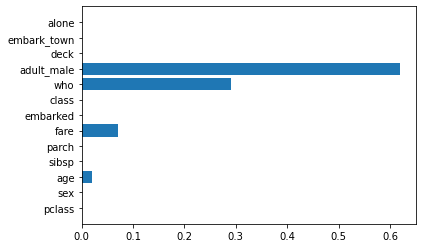

In [19]:
# AdaBoostでも特徴量の重要性を取得可能
ada.feature_importances_
plt.barh(X.columns, ada.feature_importances_)

## GBDT(回帰)を実装してみる

In [114]:
# class MyGradientBoostingDecisionTreeRegressor:
#     def __init__(self, learning_rate=0.03, n_iteration=100, max_depth=1, random_state=0):
#         self.learning_rate = learning_rate
#         self.n_iteration = n_iteration
#         self.max_depth = max_depth
#         self.random_state = random_state
    
#     def fit(self, X, y):
#         # 最初のモデルと残差を定義。最初は目的変数yの平均値を予測値とする。
#         # self.f0 = np.full((len(y),1), np.mean(y))　→ yを2次元にする必要はなし
#         # 下記では全要素がy.mean()の配列fを作成しているが、スカラーのままでもブロードキャストされるので問題ない。
#         self.y_mean = y.mean()
#         f = np.full(len(y), y.mean())
#         r = y - f
#         # 学習済みモデル格納用
#         self.models = []

#         for _ in range(self.n_iteration):
#             # 決定木のインスタンス生成、学習、学習済みモデル格納
#             model = tree.DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
#             model.fit(X, r)
#             self.models.append(model)
#             # それまでの予測結果とこのモデルの予測結果を足し合わせる
#             f += self.learning_rate * model.predict(X)
#             # 残差を更新
#             r = y - f
            
#     def predict(self, X_test):
#         # 初期の予測値はテストデータと同じシェイプにする必要あり。
#         result = self.y_mean
#         for model in self.models:
#             result += self.learning_rate * model.predict(X_test)

#         return result



上記は一応別のモジュールに分けている。

In [71]:
# tipsデータセットをインポート
df = pl.from_pandas(sns.load_dataset('mpg'))

# 今回は単純に欠損値を落とす。
df = df.drop_nulls()

# 学習データ、目的変数を定義
X = df.drop(['mpg'])
y = df.get_column('mpg')

# カテゴリ変数のカラム名をリスト化
category_cols = X.select(pl.col(pl.Utf8)).columns

# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
oe = OrdinalEncoder()
# pandasで返ってくるように指定。polarsは指定できない模様
oe.set_output(transform='pandas')
# カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
X = X.with_columns( pl.from_pandas(oe.fit_transform(X.select(category_cols).to_pandas())) )

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=0)


In [67]:
df.head()

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
f64,i64,f64,f64,i64,f64,i64,str,str
18.0,8,307.0,130.0,3504,12.0,70,"""usa""","""chevrolet chev..."
15.0,8,350.0,165.0,3693,11.5,70,"""usa""","""buick skylark ..."
18.0,8,318.0,150.0,3436,11.0,70,"""usa""","""plymouth satel..."
16.0,8,304.0,150.0,3433,12.0,70,"""usa""","""amc rebel sst"""
17.0,8,302.0,140.0,3449,10.5,70,"""usa""","""ford torino"""


In [128]:
my_gbr = MyGradientBoostingDecisionTreeRegressor(max_depth=1, learning_rate=0.03)
my_gbr.fit(X_train, y_train)

In [130]:
y_pred_my = my_gbr.predict(X_test)
y_pred_my[:20]

array([27.0977333 , 26.38157325, 15.95950963, 32.48915633, 32.48915633,
       19.88584199, 33.09168089, 27.66257833, 17.95623393, 25.65001678,
       28.97996567, 16.03803147, 24.65853126, 15.95950963, 19.33257099,
       31.13092668, 24.18746175, 15.95950963, 25.65001678, 26.92488408])

## sklearnのGBDT(回帰)

In [57]:
# sklearnのGBDT（回帰）を使う
gbr = GradientBoostingRegressor(max_depth=1, learning_rate=0.03, random_state=0).fit(X_train, y_train)

In [94]:
y_pred_sklearn = gbr.predict(X_test)
y_pred_sklearn[:20]

array([27.0977333 , 26.38157325, 15.95950963, 32.48915633, 32.48915633,
       19.88584199, 33.09168089, 27.66257833, 17.95623393, 25.65001678,
       28.97996567, 16.03803147, 24.65853126, 15.95950963, 19.33257099,
       31.13092668, 24.18746175, 15.95950963, 25.65001678, 26.92488408])

In [81]:
y_test[:10]

144    28.0
280    22.3
68     12.0
372    38.0
328    33.8
255    19.4
308    38.1
326    30.0
124    20.0
107    20.0
Name: mpg, dtype: float64

スクラッチによる実装による結果とsklearnの結果は同じになったので、  
実装として正しいと思われる。

## GBDT(分類)を実装してみる

In [134]:
model = tree.DecisionTreeRegressor(max_depth=1, random_state=0).fit(X_train, y_train)

model.applyによって、テストデータがどの葉にたどり着くのかが分かる。  
下の例では最初のデータは決定木の一番左の葉（一番目の葉）にたどり着くことを表している。  
(この例ではmax_depth=1なので葉は２つのみ)

In [138]:
model.apply(X_test)

array([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       2, 1, 1, 2, 1, 1, 1, 2])

model.tree_.valueで決定木の各ノードおよび葉の値を取得できる。  
決定木を可視化するとわかるようにノード→左からの順の葉の値が出力される。

In [141]:
model.tree_.value

array([[[23.1689781 ]],

       [[29.12428571]],

       [[16.94701493]]])

[Text(0.5, 0.75, 'x[0] <= 5.5\nsquared_error = 60.184\nsamples = 274\nvalue = 23.169'),
 Text(0.25, 0.25, 'squared_error = 32.348\nsamples = 140\nvalue = 29.124'),
 Text(0.75, 0.25, 'squared_error = 13.5\nsamples = 134\nvalue = 16.947')]

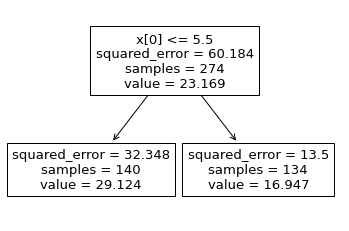

In [142]:
tree.plot_tree(model)

In [147]:
model.apply(X_test)[:10]

array([1, 1, 2, 1, 1, 2, 1, 1, 2, 1])

In [145]:
model.predict(X_test)[:10]

array([29.12428571, 29.12428571, 16.94701493, 29.12428571, 29.12428571,
       16.94701493, 29.12428571, 29.12428571, 16.94701493, 29.12428571])

In [96]:
class MyGradientBoostingDecisionTreeClassifier:
    def __init__(self, learning_rate=0.03, n_iteration=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_iteration = n_iteration
        self.max_depth = max_depth
        self.random_state = random_state
    
    def fit(self, X, y):
        # 最初の予測値と残差を定義。最初は目的変数yの平均値のオッズ比とする。
        f0 = np.log(y.mean() / (1 - y.mean()))
        f = f0
        # 学習済みモデル格納用
        self.models = []

        for _ in range(self.n_iteration):
            # 残差の更新
            r = y - (1 / (1 + np.exp(-f) ))
            # 決定木のインスタンス生成、学習、学習済みモデル格納。分類でも回帰の決定木でOK
            model = tree.DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            model.fit(X, r)
            self.models.append(model)
            # それまでの予測結果とこのモデルの予測結果を足し合わせる
            f += self.learning_rate * model.predict(X)
            
    def predict(self, X_test):
        # 初期の予測値はテストデータと同じシェイプにする必要あり。
        result = self.y_mean
        for model in self.models:
            result += self.learning_rate * model.predict(X_test)

        return result

